### 🎯 SIsA en ResNet18
Entrenamos un modelo ResNet18 con CIFAR-10 empleando SIsA. Vamos a estudiar como afecta la division del modelo en su exactitud, y la eficiencia del desaprendizaje.

In [3]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.utils import split_dataset
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

Using TensorFlow backend


In [ ]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [ ]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

___
Descargamos y preparamos los datos de CIFAR-10.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = split_dataset(held_out, left_size=0.2)

In [5]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465],
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)],
        invert=denorm,
        axis=-1,
    )

    if not denorm:
        image = rescale(image)
    return norms(image), label

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [8]:
# Esta función divide el conjunto de datos 'ds' en 'S' trozos de igua tamaño

def slice_ds(ds, S):
    sliced_datasets=[]
    for s in range(S-1):
        split1, split2 = split_dataset(ds, left_size=1/(S-s),seed=0)
        sliced_datasets.append(split1)
        ds=split2
        print('Split ', s+1, '/', S-1, ' done')
    sliced_datasets.append(split2)

    return sliced_datasets

In [19]:
Slices=16

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
sliced_datasets=slice_ds(train_ds, Slices)

for i in range(len(sliced_datasets)):
    sliced_datasets[i] = sliced_datasets[i].map(normalize)
    sliced_datasets[i] = sliced_datasets[i].shuffle(buffer_size=8*BATCH_SIZE)
    sliced_datasets[i] = sliced_datasets[i].batch(BATCH_SIZE).prefetch(AUTOTUNE)
    print(int(sliced_datasets[i].cardinality()))

Split  1 / 15  done
Split  2 / 15  done
Split  3 / 15  done
Split  4 / 15  done
Split  5 / 15  done
Split  6 / 15  done
Split  7 / 15  done
Split  8 / 15  done
Split  9 / 15  done
Split  10 / 15  done
Split  11 / 15  done
Split  12 / 15  done
Split  13 / 15  done
Split  14 / 15  done
Split  15 / 15  done
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


___
Preparamos y entrenamos los distintos modelos ResNet18, y creamos el modelo de ensamblado

In [9]:
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                ResNet18Backbone(include_rescaling=False, input_shape=(32, 32, 3)),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    return model

In [ ]:
models = []
history = [s for s in range(Slices)]

for s in range(Slices):
    model = get_model()
    models.append(model)
    
    history[s] = model.fit(sliced_datasets[s], validation_data=val_ds, epochs=20)

    model.save('sliced_models/slice_'+str(Slices)+'_'+str(s)+'.keras', save_format="keras_v3")

In [ ]:
# Análisis de la exactitud de los modelos en el conjunto de datos de entrenamiento

for s in range(Slices):
    model = models[s]
    print(f"Train set accuracy: {100.0 * model.evaluate(sliced_datasets[s])[-1]:0.1f}%%")
    print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

In [30]:
# Ensamblado de los 'S' modelos en uno, cuyo output es la media de los todos

model_input = tf.keras.Input(shape=(32, 32, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

ensemble_model.save('ensembles/ensemble_'+str(Slices)+'.keras')

In [ ]:
# Análisis de la exactitud en el conjunto de datos de entrenamiento

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"Train set accuracy: {100.0 * ensemble_model.evaluate(train_ds)[-1]:0.1f}%")
print(f"Test set accuracy: {100.0 * ensemble_model.evaluate(test_ds)[-1]:0.1f}%")

___
Comprobamos la efectividad de un MIA en el modelo de ensamblado.

In [11]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        reduction="none"
    )
    all_losses = []

    for inputs, targets in tqdm(loader):
        logits = net(inputs, training=False)
        losses = loss_fn(targets, logits).numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [12]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [14]:
# ! Preprocesar 'train_ds' antes de obtener los conjutos a olvidar y retener

forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print('A olvidar:', int(forget_set.cardinality()),', a retener:', int(retain_set.cardinality()))

A olvidar: 5000 , a retener: 45000


In [ ]:
forget_losses = compute_losses(ensemble_model, forget_ds)
test_losses = compute_losses(ensemble_model, test_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

___
Gráfica de exactitud y efectividad del MIA frente a S.

In [17]:
slices=[2,3,4,8,16]
accuracy_train=[0,0,0,0,0]
accuracy_test=[0,0,0,0,0]
mia_score=[0,0,0,0,0]

In [ ]:
ensemble_models=[]
for S in slices:
    e_model = keras.saving.load_model('ensembles/ensemble_'+str(S)+'.keras')
    ensemble_models.append(e_model)
    print('Ensemble model with', S, 'slices loaded')

In [31]:
for e in range(len(ensemble_models)):
    ensemble_model=ensemble_models[e]
    print(ensemble_model._name)
    forget_losses = compute_losses(ensemble_model, forget_ds)
    test_losses = compute_losses(ensemble_model, test_ds)

    # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[:len(test_losses)]

    samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)

    print(
        f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
    )

    accuracy_train[e]=ensemble_model.evaluate(train_ds)[-1]
    accuracy_test[e]=ensemble_model.evaluate(test_ds)[-1]
    mia_score[e]=mia_scores.mean()

model


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


The MIA attack has an accuracy of 0.527 on forgotten vs unseen images
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImple

W0000 00:00:1716639532.647511  221293 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716639532.765506  221293 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 [==============================] - 60s 104ms/step - loss: 0.9952 - accuracy: 0.6614


W0000 00:00:1716639573.349395  221293 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716639573.426871  221293 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 [==============================] - 1s 75ms/step - loss: 1.1740 - accuracy: 0.6020


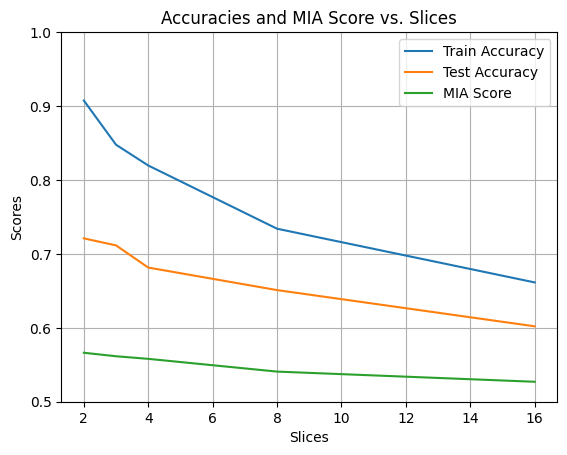

In [32]:
plt.plot(slices, accuracy_train, label='Train Accuracy')
plt.plot(slices, accuracy_test, label='Test Accuracy')
plt.plot(slices, mia_score, label='MIA Score')

plt.xlabel('Slices')
plt.ylabel('Scores')
plt.title('Accuracies and MIA Score vs. Slices')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

______
### Utilidades

In [24]:
# Cargar los modelos guardados

Slices=16

#models=[]
for s in range(14):
    model = keras.saving.load_model('sliced_models/slice_'+str(Slices)+'_'+str(s)+'.keras')
    models.append(model)
    print('Sliced model ', s, ' loaded')


Sliced model  0  loaded
Sliced model  1  loaded
Sliced model  2  loaded
Sliced model  3  loaded
Sliced model  4  loaded
Sliced model  5  loaded
Sliced model  6  loaded
Sliced model  7  loaded
Sliced model  8  loaded
Sliced model  9  loaded
Sliced model  10  loaded
Sliced model  11  loaded
Sliced model  12  loaded
Sliced model  13  loaded


In [25]:
# Renombrar modelos si se repiten los nombres

for s in range(Slices):
    models[s]._name='sequential_'+str(s)
    print(models[s]._name)

sequential_0
sequential_1
sequential_2
sequential_3
sequential_4
sequential_5
sequential_6
sequential_7
sequential_8
sequential_9
sequential_10
sequential_11
sequential_12
sequential_13
sequential_14
sequential_15


In [25]:
import pickle

# Saving the objects:
with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([slices, accuracy_train, accuracy_test, mia_score], f)

In [23]:
import pickle

# Getting back the objects:
with open('SIsA_data.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    [slices, accuracy_train, accuracy_test, mia_score] = pickle.load(f)